In [ ]:
!wget https://raw.githubusercontent.com/whopriyam/Sexual-Harassment-Classification/main/Labelled_Tweets/Cleaned_tweets.csv

--2021-04-17 16:37:40--  https://raw.githubusercontent.com/whopriyam/Sexual-Harassment-Classification/main/Labelled_Tweets/Cleaned_tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534564 (522K) [text/plain]
Saving to: ‘Cleaned_tweets.csv.1’

Cleaned_tweets.csv. 100%[===================>] 522.04K  --.-KB/s    in 0.01s   

2021-04-17 16:37:40 (51.1 MB/s) - ‘Cleaned_tweets.csv.1’ saved [534564/534564]



In [ ]:
# !mv 4572_Cleaned_tweets.csv\?token\=AJXJTMN3KH4BTSETYG7OOS3AL4DJ6 Cleaned_tweets.csv

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("Cleaned_tweets.csv")

In [ ]:
data.shape

(4572, 14)

In [ ]:
data = data.dropna(subset=['Text'])

In [ ]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Key Word,Username,User_ID,Datetime,Favorite_count,Geo,Coordinates,Label,Text,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,1150,1150,brotherfucker,sheri79923585,1.330000e+18,08-11-2020 23:22,2,NaN,NaN,0.0,If Lauren is t suggesting to deport this gross...,NaN,NaN,NaN
1,1867,1867,Aroused,schwyhart,1.330000e+18,10-11-2020 18:18,4,NaN,NaN,1.0,"F in the chat for Corbin, he’s clearly constan...",NaN,NaN,NaN
2,3883,1575,hoe,Naambo11s,1.326780e+18,2020-11-12 06:51:53,0,NaN,NaN,0.0,"Congratulations to Thando and his fiancÃ©, let...",NaN,NaN,NaN
3,1026,1026,boobies,MoonSLullabies,1.330000e+18,11-11-2020 07:41,0,NaN,NaN,0.0,if you . ♡ ° ♡ think °. ♡ . + that . ✵ ♡ ✷ ♡ ✧...,NaN,NaN,NaN
4,320,320,ass cowboy,olivialynnfahey,1.330000e+18,10-11-2020 01:33,3,NaN,NaN,0.0,"Before anyone says anything, I am gonna get a ...",NaN,NaN,NaN


In [ ]:
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics

In [ ]:
!pip3 install bert-for-tf2

In [ ]:
import tensorflow_hub as hub 
from bert import bert_tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
!ls -al .config

total 36
drwxr-xr-x 4 root root 4096 Apr  7 13:35 .
drwxr-xr-x 1 root root 4096 Apr 17 17:06 ..
-rw-r--r-- 1 root root    7 Apr  7 13:35 active_config
-rw-r--r-- 1 root root    0 Apr  7 13:36 config_sentinel
drwxr-xr-x 2 root root 4096 Apr  7 13:35 configurations
-rw------- 1 root root    5 Jan  1  2040 gce
-rw-r--r-- 1 root root    3 Apr  7 13:35 .last_opt_in_prompt.yaml
-rw-r--r-- 1 root root   37 Apr  7 13:35 .last_survey_prompt.yaml
-rw-r--r-- 1 root root  134 Apr  7 13:35 .last_update_check.json
drwxr-xr-x 3 root root 4096 Apr  7 13:35 logs


In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
max_len = 100
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data.Text, data['Label'], 
                                                                          test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, 
                                                                          test_size=0.2, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_test = bert_encode(X_test, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    X_train, y_train, 
   
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=1,
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/10
2924/2924 [==============================] - 187s 60ms/step - loss: 0.6521 - accuracy: 0.6043 - val_loss: 0.4715 - val_accuracy: 0.7855

Epoch 00001: val_accuracy improved from -inf to 0.78552, saving model to model.h5
Epoch 2/10
2924/2924 [==============================] - 174s 59ms/step - loss: 0.4217 - accuracy: 0.8127 - val_loss: 0.5102 - val_accuracy: 0.7814

Epoch 00002: val_accuracy did not improve from 0.78552
Epoch 3/10
2924/2924 [==============================] - 174s 59ms/step - loss: 0.2226 - accuracy: 0.9155 - val_loss: 0.5772 - val_accuracy: 0.7541

Epoch 00003: val_accuracy did not improve from 0.78552
Epoch 4/10
2924/2924 [==============================] - 173s 59ms/step - loss: 0.1264 - accuracy: 0.9614 - val_loss: 0.8872 - val_accuracy: 0.7773

Epoch 00004: val_accuracy did not improve from 0.78552
Epoch 5/10
2924/2924 [==============================] - 173s 59ms/step - loss: 0.0617 - accuracy: 0.9816 - val_loss: 1.3453 - val_accuracy: 0.7828

Epoch 00005: 

In [ ]:
model.evaluate(X_test, y_test)

29/29 [==============================] - 7s 213ms/step - loss: 1.1345 - accuracy: 0.7705


[1.134543776512146, 0.7704917788505554]

In [ ]:
train_history.history

{'accuracy': [0.6761285662651062,
  0.8286593556404114,
  0.9124487042427063,
  0.9613543152809143,
  0.9808481335639954,
  0.9859781265258789],
 'loss': [0.5988599061965942,
  0.4004863202571869,
  0.224542498588562,
  0.11691407114267349,
  0.061692014336586,
  0.05426584929227829],
 'val_accuracy': [0.7855191230773926,
  0.7814207673072815,
  0.7540983557701111,
  0.7773224115371704,
  0.7827869057655334,
  0.7650273442268372],
 'val_loss': [0.4714900255203247,
  0.5102348327636719,
  0.5772017240524292,
  0.8872174620628357,
  1.3453171253204346,
  1.1612154245376587]}

In [ ]:
print(X_val[0])

[[  101  2045  3849 ...     0     0     0]
 [  101  1045 10587 ...     0     0     0]
 [  101  1045  2572 ...     0     0     0]
 ...
 [  101  1996  2158 ...     0     0     0]
 [  101 26489  9488 ...     0     0     0]
 [  101  1045  1005 ...     0     0     0]]


In [ ]:
test_performance=model.evaluate(X_test,y_test)
print((test_performance))
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))



29/29 [==============================] - 6s 212ms/step - loss: 1.1345 - accuracy: 0.7705
[1.134543776512146, 0.7704917788505554]
The loss of the model on the test set : 1.134543776512146
The accuracy of the model on the test set : 77.04917788505554%


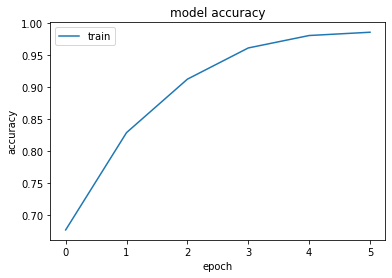

In [ ]:
plt.plot(train_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

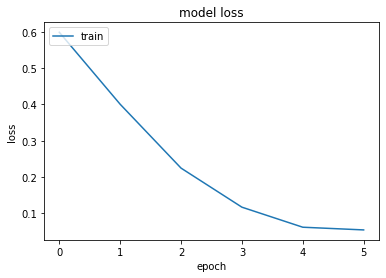

In [ ]:
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
new_input = ["hey baby come lick my gooch"]

new_val = bert_encode(new_input, tokenizer, max_len=max_len)

print(model.predict(new_val))

[[0.99998665]]


In [ ]:
model

In [ ]:
model.save('untitled_model')

INFO:tensorflow:Assets written to: untitled_model/assets


INFO:tensorflow:Assets written to: untitled_model/assets


In [ ]:
saved_model = tf.keras.models.load_model('untitled_model/')

In [ ]:
!ls -al

total 1285540
drwxr-xr-x 1 root root       4096 Apr 17 17:06 .
drwxr-xr-x 1 root root       4096 Apr 17 16:34 ..
-rw-r--r-- 1 root root     708230 Apr 17 16:35 Cleaned_tweets.csv
-rw-r--r-- 1 root root     534564 Apr 17 16:37 Cleaned_tweets.csv.1
drwxr-xr-x 4 root root       4096 Apr  7 13:35 .config
-rw-r--r-- 1 root root 1315122792 Apr 17 16:41 model.h5
drwxr-xr-x 1 root root       4096 Apr  7 13:36 sample_data
drwxr-xr-x 4 root root       4096 Apr 17 17:06 untitled_model


In [ ]:
!du -chd 1 | sort -h

96K	./.config
55M	./sample_data
1.3G	./untitled_model
2.6G	.
2.6G	total


In [ ]:
1315122792/1024/1024/1024

1.2248035445809364

In [ ]:
print(saved_model.predict(new_val)[0][0])

0.99998665


In [ ]:
!zip untitled_model untitled_model.zip

	zip warning: name not matched: untitled_model.zip

zip error: Nothing to do! (untitled_model.zip)


In [ ]:
!pip list | grep 'tensorflow'

tensorflow                    2.4.1         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.4.0         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.12.0        
tensorflow-metadata           0.29.0        
tensorflow-probability        0.12.1        


In [ ]:
!zip -r untitled_model.zip untitled_model/

updating: untitled_model/ (stored 0%)
  adding: untitled_model/assets/ (stored 0%)
  adding: untitled_model/assets/vocab.txt (deflated 53%)
  adding: untitled_model/variables/ (stored 0%)
  adding: untitled_model/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: untitled_model/variables/variables.index (deflated 82%)
  adding: untitled_model/saved_model.pb (deflated 92%)
